# Advanced Regression Analysis

The analysis should cover:
- residuals are a normal distribution
- multi-coliniairity (VIF)
- Homoschedasticity
- Pairwise regression
- Feature importance
- Model comparison (Ridge, Lasso, ElasticNet, Polynomial, and PCA-enhanced regressions)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy import stats

df = pd.read_csv('student_performance.csv')
X = df.drop('G3', axis=1)
y = df['G3']

In [3]:
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop="first"))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# 1. Inspect outliers in the dataset

### 1.1- Identify outliers in the numeric features

In [4]:
numeric_df = df[num_cols]   # only numeric features

outlier_indices = set()

for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    col_outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)].index
    outlier_indices.update(col_outliers)

print("Total outlier rows:", len(outlier_indices))


Total outlier rows: 410


### 1.2. Visualize extreme outliers variable distributions

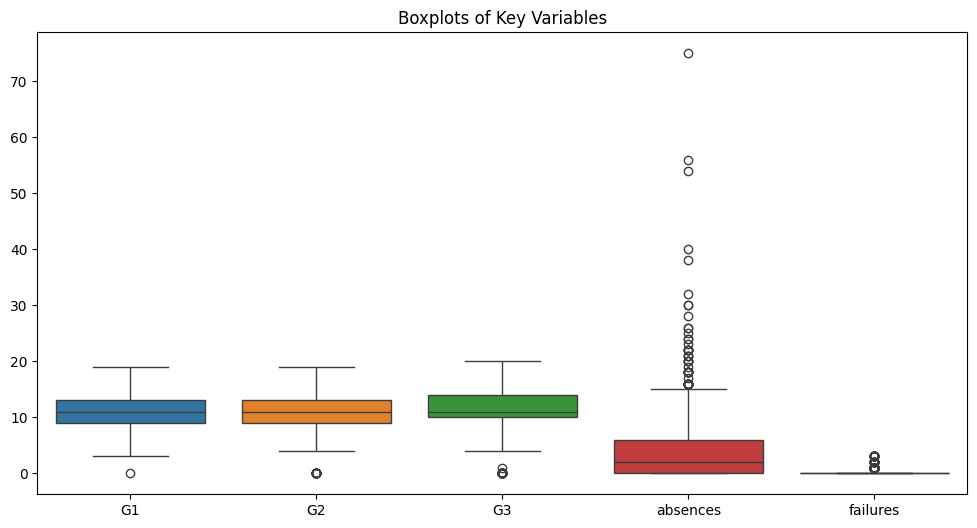

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[["G1","G2","G3","absences","failures"]])
plt.title("Boxplots of Key Variables")
plt.show()


absences has long right-tail outliers

failures has extreme values

# 2.Features correlation

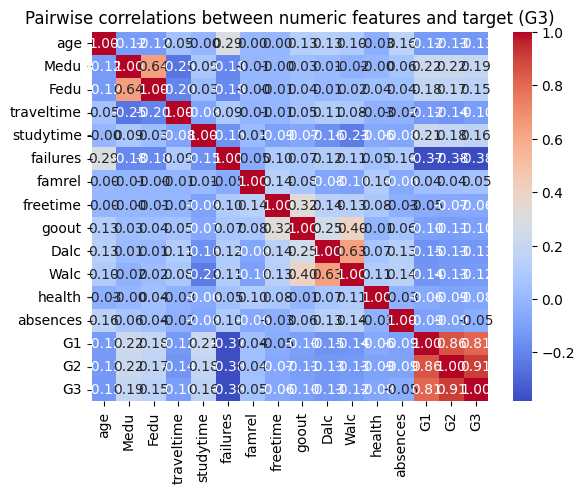

In [6]:
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'G3']
sns.heatmap(df[num_cols + ["G3"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise correlations between numeric features and target (G3)")
plt.show()


The high correlation between G1 and G3 suggests that there is multicoliniarity

# 3.Check multicoliniarity and deal with it

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Fit the preprocessor on the full X
preprocessor.fit(X)

# Transform X into the numeric design matrix
X_transformed = preprocessor.transform(X)

num_features = preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)

cat_encoder = preprocessor.named_transformers_['cat']['encoder']
cat_features = cat_encoder.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])

# Convert into a DataFrame
X_vif = pd.DataFrame(X_transformed, columns=feature_names)

# Calculate VIF for each feature

vif_list = []

for i in range(X_vif.shape[1]):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_list.append(vif)

vif_df = pd.DataFrame({
    "Feature": feature_names,
    "VIF": vif_list
})

vif_df.sort_values("VIF", ascending=False).head(20)



,Feature,VIF
37,higher_yes,12.434566
25,Fjob_other,8.919622
19,Pstatus_T,8.467943
38,internet_yes,5.753271
26,Fjob_services,5.065423
36,nursery_yes,4.936944
31,guardian_mother,4.584511
17,address_U,4.485179
13,G1,4.210977
14,G2,4.077282


# 4.Split data and model training and evaluation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = []
residuals = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    results.append((name, r2, rmse))

    residuals[name] = y_test - y_pred  # store residuals for later

results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE"]).sort_values("R²", ascending=False)
results_df



,Model,R²,RMSE
2,Lasso,0.810820,1.710229
3,ElasticNet,0.805045,1.736133
1,Ridge,0.804817,1.737149
0,Linear,0.804780,1.737315


Based on R² and RMSE, all four linear models (Linear, Ridge, Lasso, ElasticNet) show very similar predictive performance on the test set. The differences in R² are marginal, with all models explaining approximately 80% of the variance in the target variable G3. From a purely predictive standpoint, no model strongly outperforms the others.

# 5. Model validation and selection
### Let’s examine the residual distributions and normality assumptions for all models, rather than relying solely on R² for model selection.

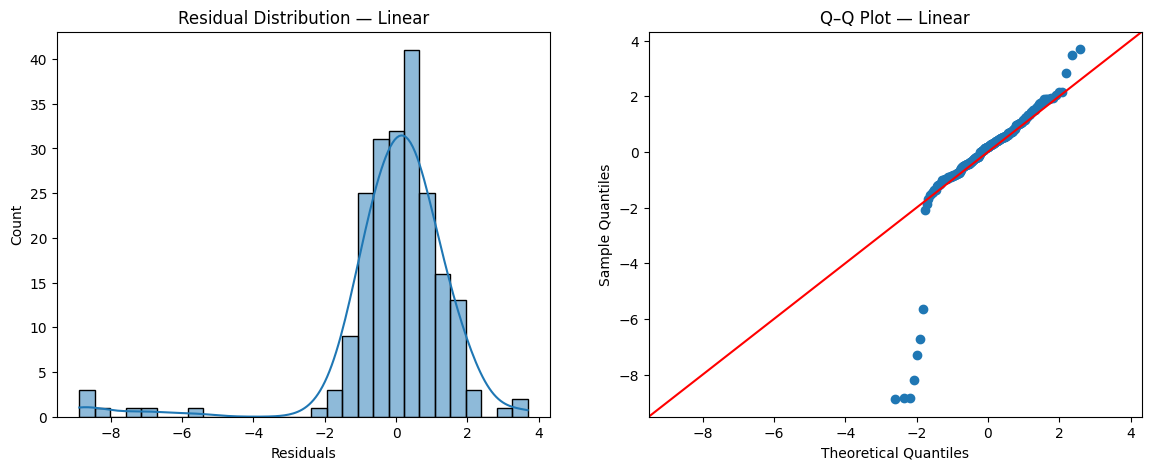

Shapiro-Wilk (Linear): statistic=0.7085, p=7.6163e-19


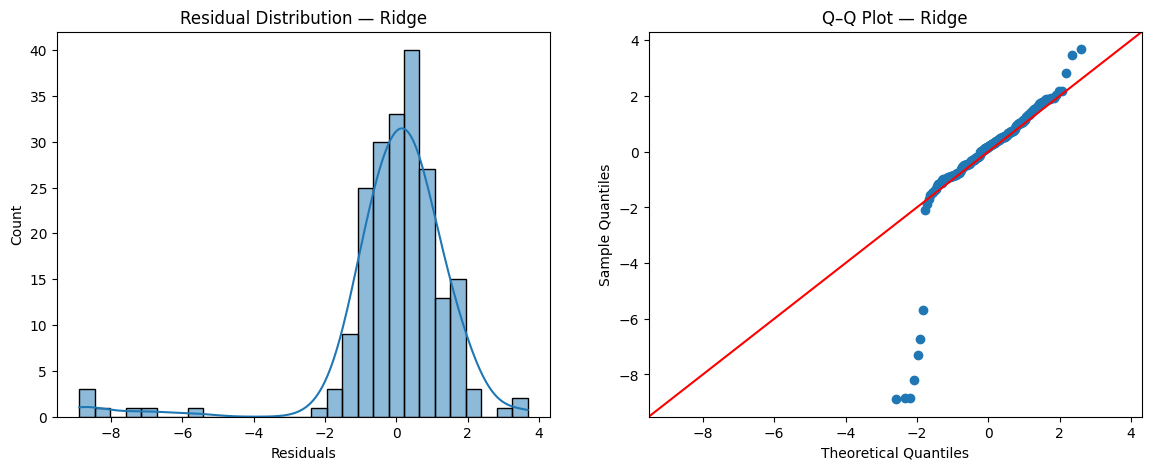

Shapiro-Wilk (Ridge): statistic=0.7081, p=7.4018e-19


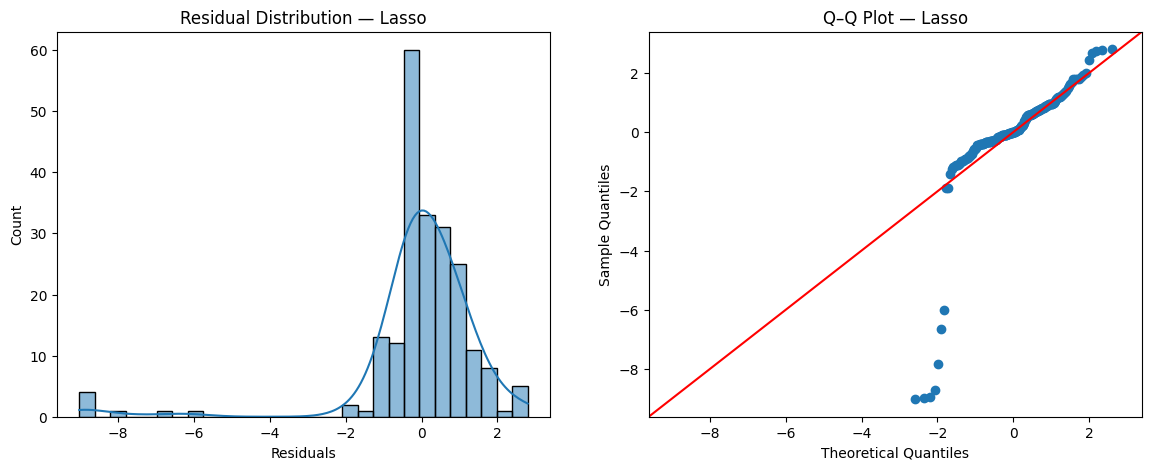

Shapiro-Wilk (Lasso): statistic=0.6343, p=6.3737e-21


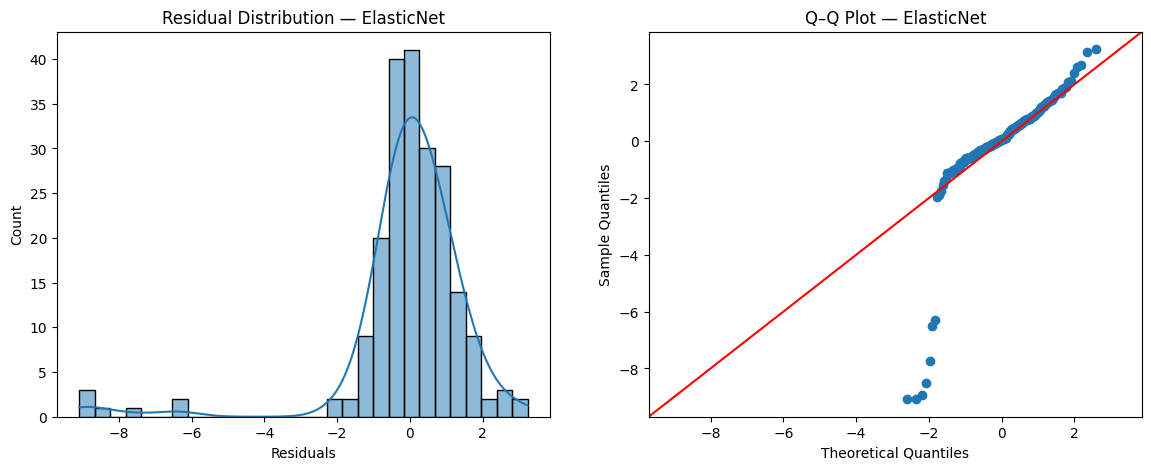

Shapiro-Wilk (ElasticNet): statistic=0.6640, p=3.9281e-20


In [10]:
import statsmodels.api as sm

def plot_residual_diagnostics(model_name, resid):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram + KDE
    sns.histplot(resid, kde=True, ax=ax[0])
    ax[0].set_title(f"Residual Distribution — {model_name}")
    ax[0].set_xlabel("Residuals")

    # Q-Q plot
    sm.qqplot(resid, line='45', ax=ax[1])
    ax[1].set_title(f"Q–Q Plot — {model_name}")

    plt.show()

    # Shapiro test
    stat, p = stats.shapiro(resid)
    print(f"Shapiro-Wilk ({model_name}): statistic={stat:.4f}, p={p:.4e}")

for model_name, resid in residuals.items():
    print("="*70)
    plot_residual_diagnostics(model_name, resid)


The p-value is too small than 0.05, which assumes that residuals are not a normal distribution (so rejection of the null hypothesis)

Even the lasso model has a higher r-square of 0.81, but the heavy left-tail at the residual distribution means that the model might make extreme errors predicting certain students.

Let's try with a non-linair model (polynomial)

### Polynomial Regression

In [11]:
poly = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

poly.fit(X_train, y_train)
y_pred_poly = poly.predict(X_test)
print('R² (polynomial):', r2_score(y_test, y_pred_poly))

R² (polynomial): -7821.766755542951


Tried also with Polynomial regression of degree 2. It performs very padly, hence the R-square is too small.

### Normal distribution of the residuals - Polynomial regression (non-lineair)

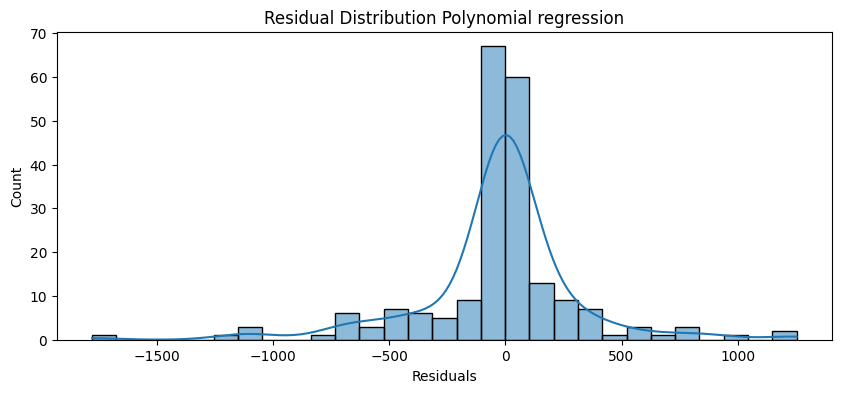

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.8221782768886827), pvalue=np.float64(1.0212998522372996e-14))


In [12]:
residuals_poly = y_test - y_pred_poly
plt.figure(figsize=(10,4))
sns.histplot(residuals_poly, kde=True)
plt.title(f"Residual Distribution Polynomial regression")
plt.xlabel("Residuals")
plt.show()

# Normality test (Shapiro-Wilk)
shapiro_test_poly = stats.shapiro(residuals_poly)
print("Shapiro-Wilk test:", shapiro_test_poly)

Based on the model comparison, Lasso regression achieves the highest R² score (≈ 0.81) among the tested linear models. However, residual diagnostics reveal that the residuals are not normally distributed, as confirmed by the Shapiro–Wilk test (p ≪ 0.05) and by the presence of a heavy left tail in the residual distribution and Q–Q plots. This indicates that the assumptions underlying linear regression are violated. Consequently, although Lasso performs best in terms of predictive accuracy among linear models, it is not statistically reliable for inference and may produce extreme prediction errors for certain students. Therefore, model selection cannot be based solely on R², and additional data treatment or alternative modeling approaches are required.

### Question to explore for students: Q1) What might affect the regression models predictions? Q2) and what are the correct next steps?

Potential answers: 
Q1) The data violates linear model assumptions, not the implementation.

Q2) Remove or cap extreme outliers
    Try with Tree-based models like Gradient boosting where normality assumption is not needed


# 6. Improve data quality 
### 6.1 Remove outliers
From step 1.2 we discoverd that absences, failures, G1 and G2 contain outliers. Particularly absences has extreme outliers. 
Instead of removing outliers, we want to capp variables with extreme outliers. Methodologically it is not a good practice removing outliers, since you risk in this dataset relevant students for the analysis. 

In [17]:
df_clean = df.copy()

# Cap extreme absences
abs_cap = df_clean["absences"].quantile(0.95)
df_clean["absences"] = df_clean["absences"].clip(upper=abs_cap)

# Cap extreme failures
fail_cap = df_clean["failures"].quantile(0.95)
df_clean["failures"] = df_clean["failures"].clip(upper=fail_cap)

print("Capping applied to absences and failures")


Capping applied to absences and failures


Check now the boxplots of those variables after capping the extreme outliers.

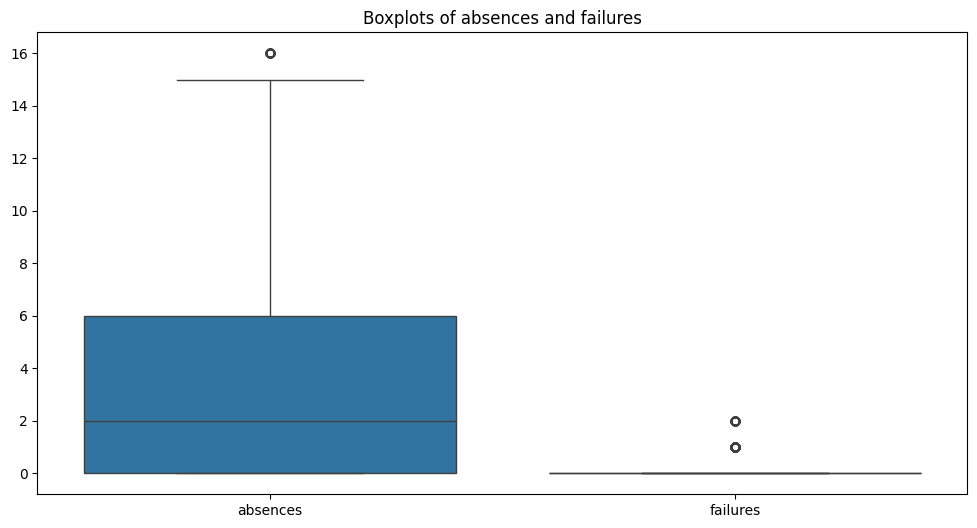

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean[["absences","failures"]])
plt.title("Boxplots of absences and failures")
plt.show()

For absences, the extreme right tail is now shortened and we do see extreme values far above the upper whisker.
And for failures, almost all values are 0 and a few students have 1-2 failures.

#### Now it is time to try our models with the cleaned data

In [19]:
X_clean = df_clean.drop("G3", axis=1)
y_clean = df_clean["G3"]

In [24]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)



In [30]:
# Refit the pipeline we already defined and used with the original dataset
results_clean = []
residuals_clean = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train_clean, y_train_clean)
    y_pred_clean = pipe.predict(X_test_clean)

    r2_clean = r2_score(y_test_clean, y_pred_clean)
    rmse_clean = root_mean_squared_error(y_test_clean, y_pred_clean)
    results_clean.append((name, r2_clean, rmse_clean))

    residuals_clean[name] = y_test_clean - y_pred_clean  # store residuals for later

results_df_clean = pd.DataFrame(results_clean, columns=["Model", "R²", "RMSE"]).sort_values("R²", ascending=False)
results_df_clean



,Model,R²,RMSE
2,Lasso,0.813499,1.698073
1,Ridge,0.809735,1.715123
0,Linear,0.809669,1.715422
3,ElasticNet,0.809307,1.717052


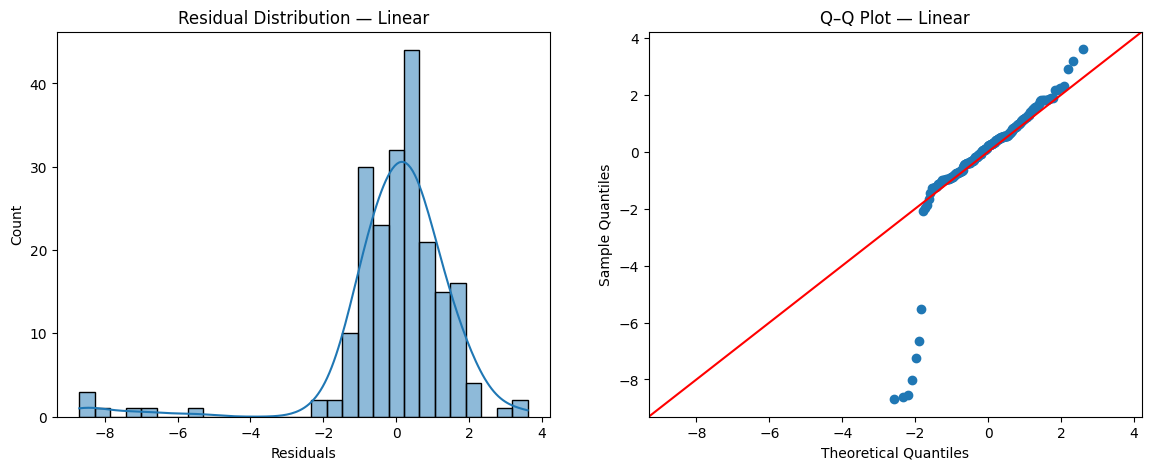

Shapiro-Wilk (Linear): statistic=0.7214, p=1.9261e-18


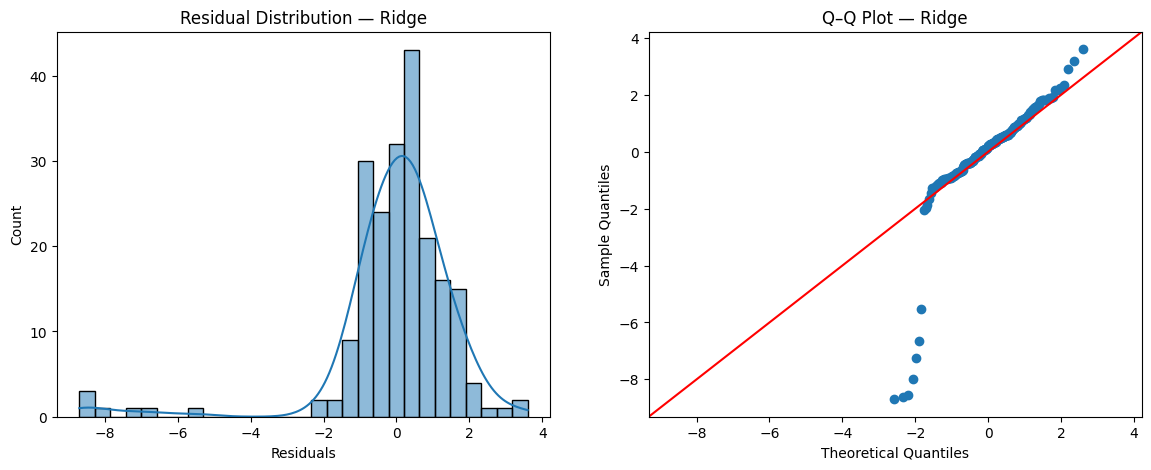

Shapiro-Wilk (Ridge): statistic=0.7209, p=1.8599e-18


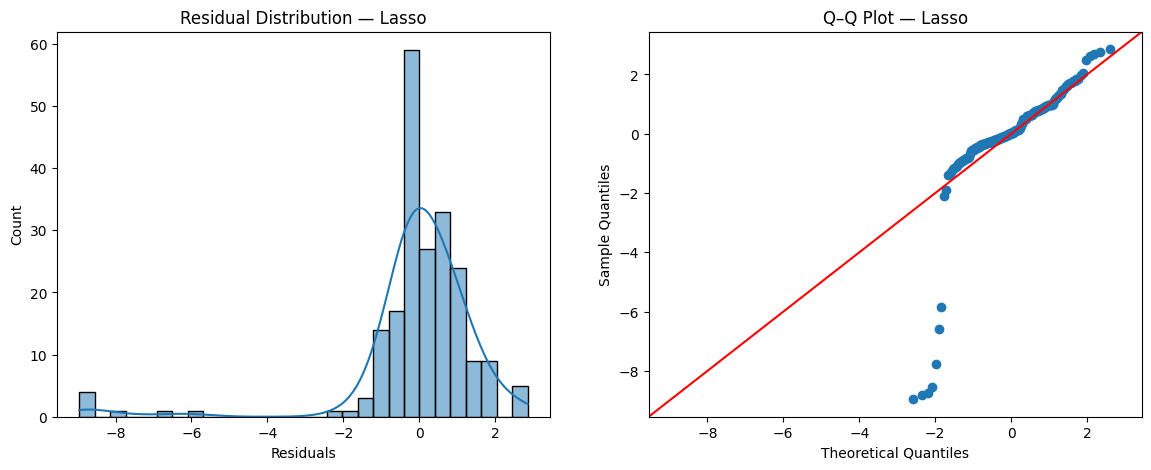

Shapiro-Wilk (Lasso): statistic=0.6467, p=1.3388e-20


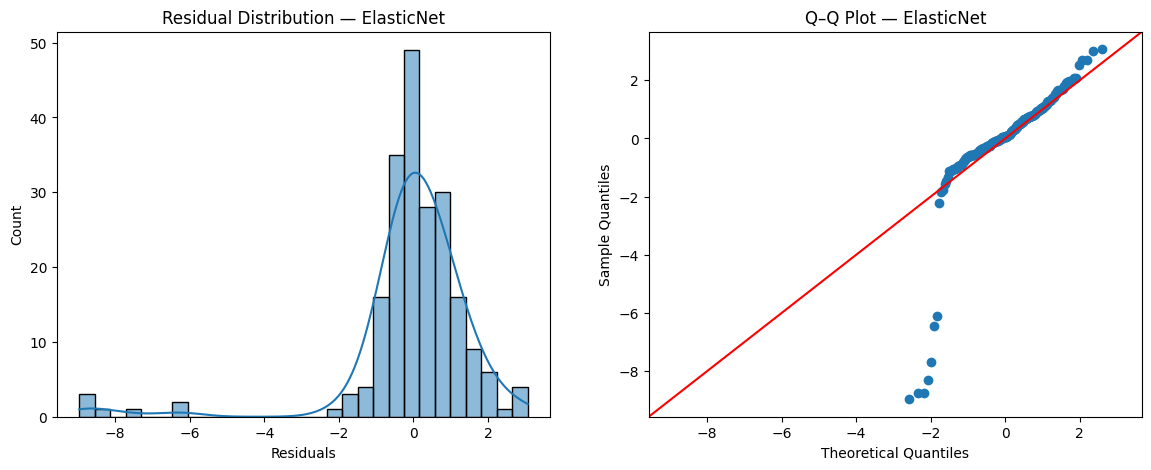

Shapiro-Wilk (ElasticNet): statistic=0.6766, p=8.7970e-20


In [31]:
for model_name, resid in residuals_clean.items():
    print("="*70)
    plot_residual_diagnostics(model_name, resid)

After winsorization of extreme values, linear regression models show slightly improved stability, but residual diagnostics still indicate violations of the normality assumption. This suggests that the remaining issues are intrinsic to the data structure rather than driven solely by extreme outliers.

In [13]:
pipe_pca = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('model', Lasso())
])

pipe_pca.fit(X_train, y_train)
print('R² (PCA Ridge):', r2_score(y_test, pipe_pca.predict(X_test)))

R² (PCA Ridge): 0.5742357846431947


In [14]:
param_grid = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_pipe = Pipeline([('prep', preprocessor), ('model', Ridge())])
grid = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='r2')
grid.fit(X, y)
print('Best alpha:', grid.best_params_)
print('Best R²:', grid.best_score_)

Best alpha: {'model__alpha': 10.0}
Best R²: 0.7951855548595488


# 8. Gradient Boosting Regression


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gbr.fit(X_train_clean, y_train_clean)
y_pred_gbr = gbr.predict(X_test_clean)

r2_gbr = r2_score(y_test_clean, y_pred_gbr)
rmse_gbr = root_mean_squared_error(y_test_clean, y_pred_gbr)

print("Gradient Boosting R²:", r2_gbr)
print("Gradient Boosting RMSE:", rmse_gbr)


Gradient Boosting R²: 0.8431073060708356
Gradient Boosting RMSE: 1.557462493444463


In [33]:
results_df_clean.loc[len(results_df_clean)] = [
    "GradientBoosting", r2_gbr, rmse_gbr
]

results_df_clean.sort_values("R²", ascending=False)


,Model,R²,RMSE
4,GradientBoosting,0.843107,1.557462
2,Lasso,0.813499,1.698073
1,Ridge,0.809735,1.715123
0,Linear,0.809669,1.715422
3,ElasticNet,0.809307,1.717052


After mitigating extreme outliers and evaluating multiple regression approaches, Gradient Boosting achieves the highest predictive performance, with a substantially higher R² and lower RMSE compared to linear and regularized regression models. Earlier residual diagnostics demonstrated persistent violations of linear regression assumptions, indicating that the underlying relationship between predictors and final grades is non-linear. Since Gradient Boosting does not rely on linearity or residual normality assumptions and exhibits superior predictive accuracy, it is the most appropriate model for this dataset.

## 8.1. Extra validation of the Gradient boosting using cross-validation

In [34]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    gbr,
    X_clean,
    y_clean,
    cv=5,
    scoring="r2"
)

print("Gradient Boosting CV R² mean:", cv_scores.mean())
print("Gradient Boosting CV R² std :", cv_scores.std())


Gradient Boosting CV R² mean: 0.782621401277491
Gradient Boosting CV R² std : 0.04724015210777389


CV R^2 mean means that on average, across 5 different train/validation splits, Gradient Boosting explains ~78% of the variance in unseen data.
The standard deviation suggests that the model’s performance varies by about ±0.05 R² across folds. Which is normal for relatively small datasets

These results confirm that the Gradient Boosting model generalizes well and does not rely on optimistic performance estimates from a single train–test split.

## Streamlit App - Deployment

First we need to save the pipeline, the caps and the column order

In [35]:
import joblib

bundle = {
    "model": gbr,
    "abs_cap": float(abs_cap),
    "fail_cap": float(fail_cap),
    "columns": X_clean.columns.tolist()
}

joblib.dump(bundle, "gbr_student_model.joblib")
print("Saved: gbr_student_model.joblib")

Saved: gbr_student_model.joblib


In [15]:
X['school'].unique()

array(['GP', 'MS'], dtype=object)

In [16]:
import streamlit as st
# Feature selection on sidebar
def get_user_input():
    school = st.sidebar.selectbox('School', ['GP', 'MS'])